In [42]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

### Data Preparation

In [24]:
p = Path("Dataset")
dirs = p.glob("*")
 
imagesData = []
labels = []

labelsDict = {"Pikachu":0,"Bulbasaur":1,"Meowth":2}
label2Pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Meowth"}

for folders in dirs:
    label = str(folders).split("\\")[-1]
    cnt = 0
    print(folders)
    for imagePath in folders.glob("*.jpg"):
        img = image.load_img(imagePath,target_size=(40,40))
        imgArr = image.img_to_array(img)
        imagesData.append(imgArr)
        labels.append(labelsDict[label])
        cnt += 1
    print(cnt)

Dataset\Bulbasaur
173
Dataset\Meowth
70
Dataset\Pikachu
199


In [31]:
X = np.array(imagesData)
Y = np.array(labels)

X,Y = shuffle(X,Y,random_state = 2)
X = X/255.0
print(X.shape,Y.shape)

(442, 40, 40, 3) (442,)


In [32]:
def drawImg(img,label):
    plt.title(label2Pokemon[label])
    plt.imshow(img)
    plt.show()

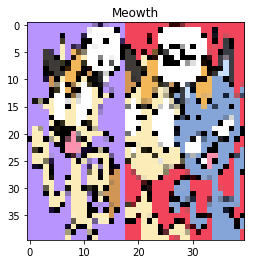

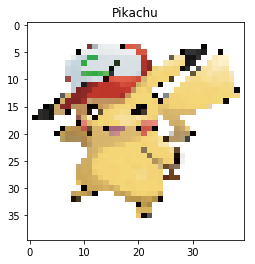

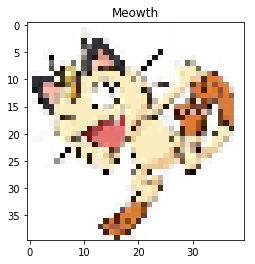

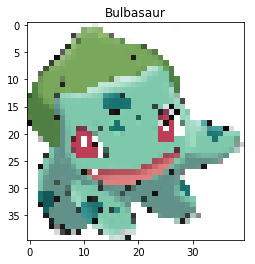

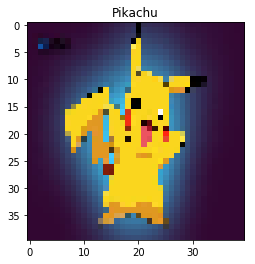

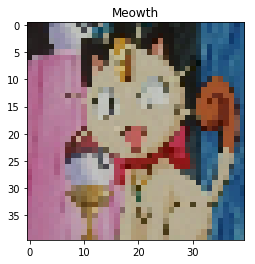

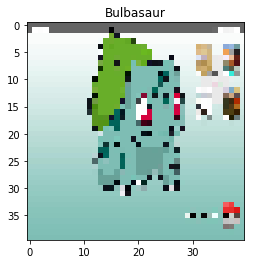

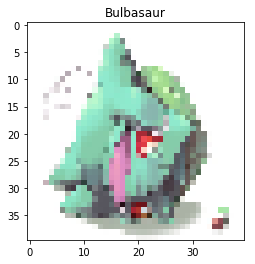

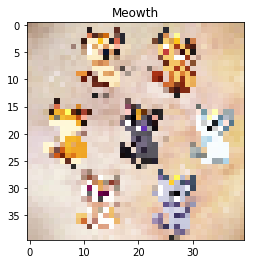

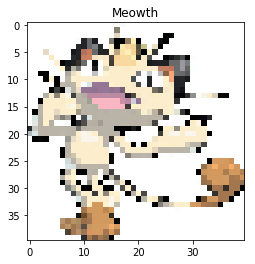

In [33]:
for i in range(10):
    r = np.random.randint(400)
    drawImg(X[r],Y[r])

### Spliting Data into Train and Test

In [34]:
split = int(X.shape[0]*.8)

X = np.array(X)
Y = np.array(Y)

XTrain = X[:split,:]
YTrain = Y[:split]

XTest = X[split:,:]
YTest = Y[split:]

print(XTrain.shape,YTrain.shape)
print(XTest.shape,YTest.shape)


(353, 40, 40, 3) (353,)
(89, 40, 40, 3) (89,)


### Training

In [91]:
class NeuralNetwork:
    
    def __init__(self,inputSize,layers,outputSize):
        np.random.seed(0)
        
        model = {}
        
        model['W1'] = np.random.randn(inputSize,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        model['W3'] = np.random.randn(layers[1],outputSize)
        model['b3'] = np.zeros((1,outputSize))
        
        self.model = model
        self.activations = None
    
    def forward(self,x):
        
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,w1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1,w2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,w3) + b3
        yPred = softmax(z3)
        
        self.activations = (a1,a2,yPred) 
        return yPred
    
    def backword(self,x,y,learningRate = 0.0001):
        
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,yPred = self.activations
        
        delta3 = yPred - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis = 0)
        
        delta2 = (1 - np.square(a2))*np.dot(delta3,w3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis = 0)
        
        delta1 = (1 - np.square(a1))*np.dot(delta2,w2.T)
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis = 0)
        
        #Updating parameters using Gradient Descent
        self.model['W1'] -= learningRate*dw1
        self.model['b1'] -= learningRate*db1
        
        self.model['W2'] -= learningRate*dw2
        self.model['b2'] -= learningRate*db2
        
        self.model['W3'] -= learningRate*dw3
        self.model['b3'] -= learningRate*db3
        
    def predict(self,x):
        yOut = self.forward(x)
        return np.argmax(yOut,axis = 1)
    
    def summary(self):
        w1,w2,w3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,yPred = self.activations
        
        print('W1 ',W1.shape)
        print('A1',a1.shape)
        print('W2 ',W2.shape)
        print('A2',a2.shape)
        print('W3 ',W3.shape)
        print('YPred',yPred.shape) 

def softmax(a):
    exA = np.exp(a)
    ans = exA/np.sum(exA,axis = 1,keepdims=True)
    return ans

In [92]:
def loss(yOneHot,p):
    l = -np.mean(yOneHot*np.log(p))
    return l

def oneHot(y,classes):
    m = y.shape[0]
    yOH = np.zeros((m,classes))
    yOH[np.arange(m),y] = 1
    return yOH

In [109]:
def train(X,Y,model,epochs,learningRate,logs = True):
    trainingLoss = []
    
    nOfClasses = len(np.unique(Y))
    
    yOH = oneHot(Y,nOfClasses)
    
    for i in range(epochs):
        yPred = model.forward(X)
        l = loss(yOH,yPred)
        trainingLoss.append(l)
        model.backword(X,yOH,learningRate)
        if(logs and i%50 == 0):
            print("Epoch %d loss is %.4f"%(i,l))
        
    return trainingLoss

In [114]:
model = NeuralNetwork(inputSize = 4800,layers=[100,50],outputSize = 3)

In [115]:
XTrain = XTrain.reshape(XTrain.shape[0],-1)
print(XTrain.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(353, 4800)
(89, 4800)


In [116]:
loss = train(XTrain,YTrain,model,500,0.0002)

Epoch 0 loss is 3.2316
Epoch 50 loss is 0.2902
Epoch 100 loss is 0.1460
Epoch 150 loss is 0.1018
Epoch 200 loss is 0.0796
Epoch 250 loss is 0.0626
Epoch 300 loss is 0.0528
Epoch 350 loss is 0.0457
Epoch 400 loss is 0.0401
Epoch 450 loss is 0.0357


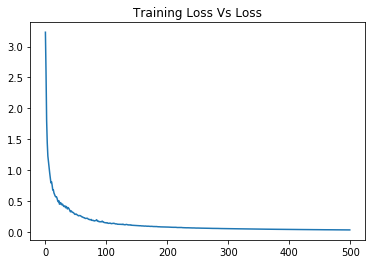

In [118]:
plt.title("Training Loss Vs Loss")
plt.plot(loss)
plt.show()

### Accuracy & Confusion Matrix

In [68]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

In [130]:
print("Training Accuracy %.4f"%getAccuracy(XTrain,YTrain,model))
print("Test Accuracy %.4f"%getAccuracy(XTest,YTest,model))

Training Accuracy 0.9802
Test Accuracy 0.5618


In [79]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Predicting and calculating Accuracy

In [142]:
outputsTrain = model.predict(XTrain)
cnfTrain = confusion_matrix(outputsTrain,YTrain)

Confusion matrix, without normalization
[[160   1   3]
 [  0 131   2]
 [  1   0  55]]


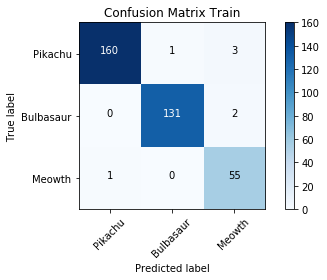

In [146]:
plot_confusion_matrix(cnfTrain,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix Train")

In [150]:
print(classification_report(outputsTrain,YTrain))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       164
           1       0.99      0.98      0.99       133
           2       0.92      0.98      0.95        56

   micro avg       0.98      0.98      0.98       353
   macro avg       0.97      0.98      0.97       353
weighted avg       0.98      0.98      0.98       353



#### Confusion Matrix for Test Data

In [148]:
outputsTest = model.predict(XTest)
cnfTest = confusion_matrix(outputsTest,YTest)

Confusion matrix, without normalization
[[21  7  5]
 [10 28  4]
 [ 7  6  1]]


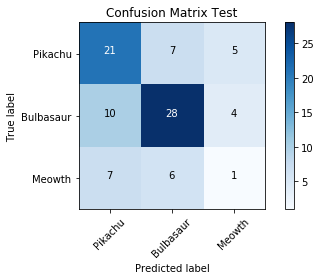

In [149]:
plot_confusion_matrix(cnfTest,classes=["Pikachu","Bulbasaur","Meowth"],title="Confusion Matrix Test")

In [151]:
print(classification_report(outputsTest,YTest))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59        33
           1       0.68      0.67      0.67        42
           2       0.10      0.07      0.08        14

   micro avg       0.56      0.56      0.56        89
   macro avg       0.45      0.46      0.45        89
weighted avg       0.54      0.56      0.55        89



#### F1-Score = 56%

### Visualise Misclassifications

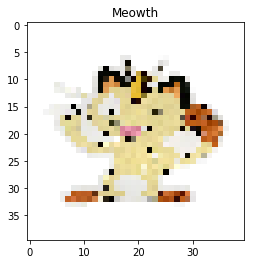

Prediction =  51 Bulbasaur


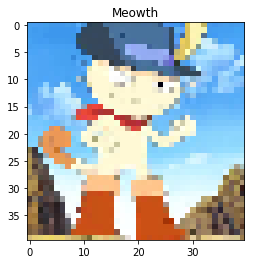

Prediction =  171 Pikachu


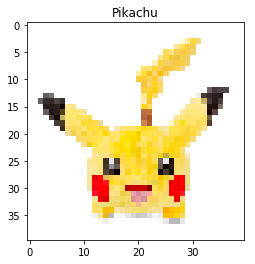

Prediction =  176 Meowth


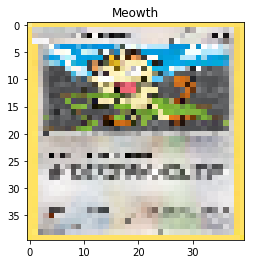

Prediction =  199 Pikachu


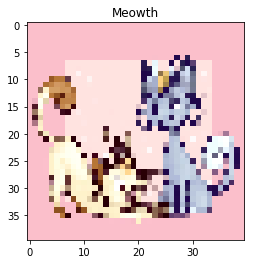

Prediction =  263 Pikachu


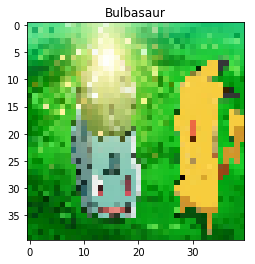

Prediction =  310 Pikachu


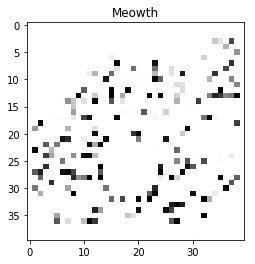

Prediction =  351 Bulbasaur


In [152]:
for i in range(YTrain.shape[0]):
    if YTrain[i] != outputsTrain[i]:
        drawImg(XTrain[i].reshape(40,40,3),YTrain[i])
        print("Prediction =  %d %s"%(i,label2Pokemon[outputsTrain[i]]))

### Improving Accuracy and avoiding misclassifications by using CNN

In [35]:
print(XTrain.shape,YTrain.shape)
print(XTest.shape,YTest.shape)

(353, 40, 40, 3) (353,)
(89, 40, 40, 3) (89,)


In [48]:
YTrainNew = to_categorical(YTrain)
YTestNew = to_categorical(YTest)

In [50]:
print(YTrainNew.shape,YTestNew.shape)

(353, 3) (89, 3)


### Training CNN Model

In [44]:
#early stopping is used to prevent overfitting i.e trainig is stopped as soon as we get the best accuracy or least loss
earlyStopping = EarlyStopping(min_delta = 0.001,monitor='val_acc', patience = 5)
callback = [earlyStopping]

#checkpoint to store the best fit model
checkpoint = ModelCheckpoint("best_model.h5",monitor='val_loss',verbose=True,save_best_only=True)

modelCNN = Sequential()
modelCNN.add(Conv2D(64,(3,3),activation='relu',input_shape=(40,40,3)))
modelCNN.add(MaxPool2D((2,2)))
modelCNN.add(Conv2D(64,(3,3),activation='relu'))
modelCNN.add(MaxPool2D((2,2)))
modelCNN.add(Conv2D(128,(3,3),activation='relu'))
modelCNN.add(Dropout(0.4))
modelCNN.add(Flatten())
modelCNN.add(Dense(64,activation='relu'))
modelCNN.add(Dense(3,activation='softmax'))
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 38, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
__________

In [45]:
modelCNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [46]:
hist = modelCNN.fit(XTrain,YTrainNew,batch_size=32,epochs=100,shuffle=True,validation_split=0.2,callbacks=[checkpoint,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Train on 282 samples, validate on 71 samples
Epoch 1/100
282/282 [==============================] - 5s 17ms/step - loss: 1.0019 - acc: 0.5319 - val_loss: 0.7290 - val_acc: 0.7887

Epoch 00001: val_loss improved from inf to 0.72897, saving model to best_model.h5
Epoch 2/100
282/282 [==============================] - 2s 7ms/step - loss: 0.6335 - acc: 0.7730 - val_loss: 0.4863 - val_acc: 0.8028

Epoch 00002: val_loss improved from 0.72897 to 0.48634, saving model to best_model.h5
Epoch 3/100
282/282 [==============================] - 2s 7ms/step - loss: 0.4331 - acc: 0.8440 - val_loss: 0.3225 - val_acc: 0.8592

Epoch 00003: val_loss improved from 0.48634 to 0.32250, saving model to best_model.h5
Epoch 4/100
282/282 [==============================] - 2s 7ms/step - loss: 0.3156 - acc: 0.8652 - val_loss: 0.1792 - val_acc: 0.9577

Epoch 00004: val_loss improved from 0.32250 to 0.17921, saving model to best_model.h5
Epoch 5/100
282/282 [=========

### Predicting & Evaluating

In [74]:
modelCNN.load_weights('best_model.h5')
print(modelCNN.evaluate(XTest,YTestNew))
print(modelCNN.evaluate(XTrain,YTrainNew))

89/89 [==============================] - 0s 2ms/step
[0.3704792880610134, 0.8876404541262081]
353/353 [==============================] - 1s 2ms/step
[0.12918867529620529, 0.9518413597733711]


In [70]:
def getAccuracyCNN(X,Y,model):
    outputs = model.predict_classes(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc

In [82]:
print("Training Accuracy : ", getAccuracyCNN(XTrain,YTrain,modelCNN).round(4)*100,'%')
print("Test Accuracy : " , getAccuracyCNN(XTest,YTest,modelCNN).round(4)*100,'%')

Training Accuracy :  95.17999999999999 %
Test Accuracy :  88.75999999999999 %


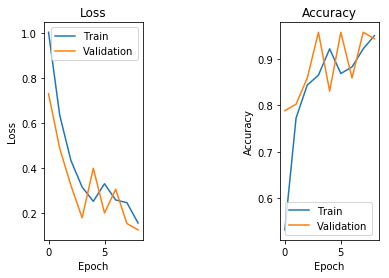

In [55]:
# Visualising Loss and Accuracy
plt.subplot(1,3,1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train', 'Validation'])

plt.subplot(1,3,3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Train', 'Validation'])
plt.show()

In [57]:
predXTrain = modelCNN.predict_classes(XTrain)
predXTest = modelCNN.predict_classes(XTest)

In [58]:
cnfTrainCNN = confusion_matrix(predXTrain,YTrain)
cnfTestCNN = confusion_matrix(predXTest,YTest)

#### Comfusion Matrix for Training Data

Confusion matrix, without normalization
[[153   0   2]
 [  2 129   4]
 [  6   3  54]]


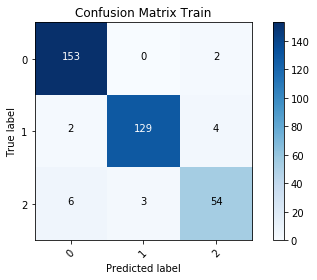

In [62]:
plot_confusion_matrix(cnfTrainCNN,classes=[0,1,2],title="Confusion Matrix Train")

In [63]:
print(classification_report(predXTrain,YTrain))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       155
           1       0.98      0.96      0.97       135
           2       0.90      0.86      0.88        63

   micro avg       0.95      0.95      0.95       353
   macro avg       0.94      0.93      0.94       353
weighted avg       0.95      0.95      0.95       353



#### Confusion Matrix for Test Data

Confusion matrix, without normalization
[[32  1  0]
 [ 3 39  2]
 [ 3  1  8]]


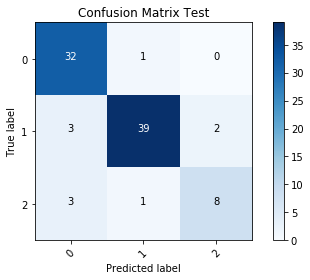

In [64]:
plot_confusion_matrix(cnfTestCNN,classes=[0,1,2],title="Confusion Matrix Test")

In [66]:
print(classification_report(predXTest,YTest))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        33
           1       0.95      0.89      0.92        44
           2       0.80      0.67      0.73        12

   micro avg       0.89      0.89      0.89        89
   macro avg       0.86      0.84      0.85        89
weighted avg       0.89      0.89      0.89        89



#### F1- score = 89%

#### Hence,CNN model gives almost double the accuracy than Multilayer Perceptron and hence the better predictions